In [45]:
using Distributions, ForwardDiff, LinearAlgebra, Gadfly

include("iGMRF.jl");
include("dataGen.jl");
include("framework.jl");
include("CAVI.jl");
include("plotting.jl");

In [74]:
# Seed
Random.seed!(400);
# Dimensions de la grille
m₁ = 10;
m₂ = 10;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 10.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

# Itérations

In [75]:
n_epoch = 100;

MCKL, Hθ = runCAVI(n_epoch, 1000, F=F, Y=Y);

Initialization made in 11.465034875 s
Minimization made in 20.721673167 s


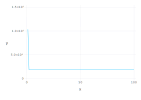

In [76]:
plot(x=1:n_epoch, y=MCKL, Geom.line)

In [77]:
η = Hθ[1:m];
bᵤ = Hθ[m + 1];
aᵤ = compute_aᵤ(m);
s² = compute_s²(aᵤ, bᵤ, length(Y[1]), [diag(F.G.W)...]);

In [ ]:
include("mcmc.jl");

niter = 10000
δ² = 0.2
κᵤ₀ = 10
μ₀ = zeros(m)

θ = gibbs(niter, Y, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

warming_size = Int(0.2 * niter);
θsampling = θ[warming_size:end, :, :];

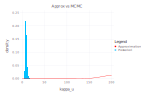

In [79]:
# Pour κᵤ

approxDensity(x::Real) = pdf(Gamma(aᵤ, bᵤ), x)
a = 0;
step = 0.1;
b = 200;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 1, 1],
    # "/plots/mean_field/approxvsmcmc_kappa.png",
    a=a,
    b=b,
    step=step;
    xLabel="kappa_u",
    yLabel="density",
)

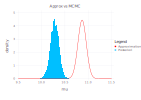

In [80]:
# Pour μ

approxDensity(x::Real) = pdf(Normal(η[1], sqrt(s²[1])), x);
a = 9.5;
b = 11.5;
step = .001;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 2, 1],
    # "../plots/precision/approxvsmcmc_mu.png",
    a=a,
    b=b,
    step=step,
    xLabel="mu",
    yLabel="density",
)